## Import necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import the data

In [341]:
bom = pd.read_csv("data/bom.movie_gross.csv.gz")
imdb_names = pd.read_csv("data/imdb.name.basics.csv.gz")
# imdb_title_akas = pd.read_csv("data/imdb.title.akas.csv.gz")
imdb_title_basics = pd.read_csv("data/imdb.title.basics.csv.gz")
# imdb_title_princ = pd.read_csv("data/imdb.title.principals.csv.gz")
imdb_title_ratings = pd.read_csv("data/imdb.title.ratings.csv.gz")
tmdb = pd.read_csv("data/tmdb.movies.csv.gz")
rt_movie_info = pd.read_csv('data/rt.movie_info.tsv.gz', sep='\t')
rt_reviews = pd.read_csv("data/rt.reviews.tsv.gz", sep='\t', encoding='latin-1')
tn_movie_budgets = pd.read_csv("data/tn.movie_budgets.csv.gz", sep=',')

In [565]:
imdb_names[imdb_names.primary_name == 'Tom Holland']

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
88037,nm0276169,Tom Holland,1943.0,NaN,"actor,writer,director","tt0089175,tt1438176,tt0112040,tt0094862"
399307,nm4043618,Tom Holland,1996.0,NaN,"actor,director,miscellaneous","tt3498820,tt4154756,tt2250912,tt1649419"


In [342]:
tn_movie_budgets.shape

(5782, 6)

In [343]:
inner_bom_tmdb = bom.merge(tmdb, left_on='title', right_on='title')

In [344]:
imdb_title_basics = pd.read_csv("data/imdb.title.basics.csv.gz")

In [248]:
brad_pitt = imdb_names[imdb_names['primary_name'] == 'Brad Pitt'].copy()
brad_pitt2 = brad_pitt.copy()

In [249]:
brad_pitt

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
24026,nm0000093,Brad Pitt,1963.0,NaN,"actor,producer,soundtrack","tt1210166,tt0114746,tt0356910,tt0816711"


In [56]:
brad_pitt[['movie_1', 'movie_2', 'movie_3', 'movie_4']] = brad_pitt.apply(lambda x: pd.Series(x['known_for_titles'].split(',')), axis=1)

In [55]:
brad_pitt.apply(lambda x: pd.Series(x['known_for_titles'].split(',')), axis=1).stack()

24026  0    tt1210166
       1    tt0114746
       2    tt0356910
       3    tt0816711
dtype: object

In [60]:
brad_pitt_melt = brad_pitt.melt(id_vars='primary_name', value_vars=['movie_1', 'movie_2', 'movie_3', 'movie_4'])

In [61]:
brad_pitt_melt.merge(brad_pitt, left_on='primary_name', right_on='primary_name')

,primary_name,variable,value,nconst,birth_year,death_year,primary_profession,known_for_titles,kft,movie_1,movie_2,movie_3,movie_4
0,Brad Pitt,movie_1,tt1210166,nm0000093,1963.0,NaN,"actor,producer,soundtrack","tt1210166,tt0114746,tt0356910,tt0816711",tt1210166,tt1210166,tt0114746,tt0356910,tt0816711
1,Brad Pitt,movie_2,tt0114746,nm0000093,1963.0,NaN,"actor,producer,soundtrack","tt1210166,tt0114746,tt0356910,tt0816711",tt1210166,tt1210166,tt0114746,tt0356910,tt0816711
2,Brad Pitt,movie_3,tt0356910,nm0000093,1963.0,NaN,"actor,producer,soundtrack","tt1210166,tt0114746,tt0356910,tt0816711",tt1210166,tt1210166,tt0114746,tt0356910,tt0816711
3,Brad Pitt,movie_4,tt0816711,nm0000093,1963.0,NaN,"actor,producer,soundtrack","tt1210166,tt0114746,tt0356910,tt0816711",tt1210166,tt1210166,tt0114746,tt0356910,tt0816711


In [62]:
brad_pitt_melt

,primary_name,variable,value
0,Brad Pitt,movie_1,tt1210166
1,Brad Pitt,movie_2,tt0114746
2,Brad Pitt,movie_3,tt0356910
3,Brad Pitt,movie_4,tt0816711


In [97]:
imdb_head = imdb_title_basics.head().copy()

In [98]:
imdb_head['genres_list'] = imdb_head.genres.str.split(',')

In [121]:
s = imdb_head.apply(lambda x: pd.Series(x['genres_list']), axis=1).stack().reset_index(level=1, drop=True)

In [125]:
s.name = 'Genres'
imdb_genres = imdb_head.join(s).copy()

In [133]:
genres_dummies = pd.get_dummies(imdb_genres.Genres).sum(level=0)

In [136]:
imdb_head.join(genres_dummies).drop(['genres', 'genres_list'], axis=1)

,tconst,primary_title,original_title,start_year,runtime_minutes,Action,Biography,Comedy,Crime,Drama,Fantasy
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,1,0,0,1,1,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,0,1,0,0,1,0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,0,0,0,0,1,0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,0,0,1,0,1,0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,0,0,1,0,1,1


### One-Hot Encode Genres for Every Movie

In [345]:
def OHE_genres(movie_list):
    movie_list['genres_list'] = movie_list.genres.str.split(',')
    s = movie_list.apply(lambda x: pd.Series(x['genres_list']), 
                                             axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'Genres'
    imdb_genres = movie_list.join(s).copy()
    genres_dummies = pd.get_dummies(imdb_genres.Genres).sum(level=0)
    ml = movie_list.join(genres_dummies).drop(['genres', 'genres_list'], axis=1)
    return ml

In [348]:
imdb_title_basics.set_index('tconst', inplace=True)
imdb_movie_data = imdb_title_basics.merge(imdb_title_ratings, left_index=True, right_on='tconst')
inner_bom_imdb = bom.merge(imdb_movie_data, left_on='title', right_on='primary_title')

In [349]:
inner_bom_imdb.set_index('tconst', inplace=True)

In [350]:
inner_bom_imdb = OHE_genres(inner_bom_imdb)

In [351]:
inner_bom_imdb.head()

,title,studio,domestic_gross,foreign_gross,year,primary_title,original_title,start_year,runtime_minutes,averagerating,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0315642,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
tt0337692,On the Road,IFC,744000.0,8000000,2012,On the Road,On the Road,2012,124.0,6.1,...,0,0,0,0,1,0,0,0,0,0
tt0359950,The Secret Life of Walter Mitty,Fox,58200000.0,129900000,2013,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,7.3,...,0,0,0,0,0,0,0,0,0,0
tt0365907,A Walk Among the Tombstones,Uni.,26300000.0,26900000,2014,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,6.5,...,0,0,0,0,0,0,0,0,0,0
tt0369610,Jurassic World,Uni.,652300000.0,"1,019.4",2015,Jurassic World,Jurassic World,2015,124.0,7.0,...,0,0,0,0,0,1,0,0,0,0


### Fixing Movie Gross Problems

In [352]:
inner_bom_imdb.loc[inner_bom_imdb.foreign_gross == '1,019.4','foreign_gross'] = 1_019_440_000
inner_bom_imdb.loc[inner_bom_imdb.foreign_gross == '1,010.0', 'foreign_gross'] = 1_010_000_000
inner_bom_imdb.loc[inner_bom_imdb.foreign_gross == '1,369.5','foreign_gross'] = 1_369_500_000
inner_bom_imdb.loc[inner_bom_imdb.foreign_gross == '1,163.0','foreign_gross'] = 1_163_000_000

In [353]:
inner_bom_imdb['total_gross'] = inner_bom_imdb['domestic_gross'] + inner_bom_imdb.foreign_gross.astype(float).fillna(0)



In [354]:
null_box_office = inner_bom_imdb[inner_bom_imdb.domestic_gross.isna()].index

In [355]:
inner_bom_imdb = inner_bom_imdb.drop(null_box_office)

### Making Each Movie in names a row

In [259]:
names = imdb_names.copy()
names2 = imdb_names.copy()

In [250]:
brad_pitt['kft'] = brad_pitt.known_for_titles.str.split(',')
s = brad_pitt.apply(lambda x: pd.Series(x['kft']), axis=1).stack().reset_index(level=1, drop=True)
s.name = "Known_Movies"
brad_pitt_movies = brad_pitt.join(s).drop(['nconst', 'birth_year',
                                           'death_year', 
                                           'known_for_titles', 'kft', 'primary_profession'], axis=1)

In [260]:
names['kft'] = names.known_for_titles.str.split(',')
s = names.apply(lambda x: pd.Series(x['kft']), axis=1).stack().reset_index(level=1, drop=True)
s.name = "Known_Movies"
names_movies = names.join(s).drop(['nconst', 'birth_year',
                                           'death_year', 
                                           'known_for_titles', 'kft', 'primary_profession'], axis=1)

In [268]:
names_movies.set_index('Known_Movies', inplace=True)

In [256]:
brad_pitt2['profs'] = brad_pitt2.primary_profession.str.split(',')
s = brad_pitt2.apply(lambda x: pd.Series(x['profs']), 
                                         axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Professions'
brad_pitt_profs = brad_pitt2.join(s).copy()
profs_dummies = pd.get_dummies(brad_pitt_profs.Professions).sum(level=0)
brad_pitt_profs = brad_pitt_profs.join(profs_dummies)
brad_pitt_profs.drop(['nconst', 'birth_year', 'death_year', 'known_for_titles',
                      'primary_profession', 'Professions', 'profs'], axis=1, inplace=True)
brad_pitt_profs.drop_duplicates(inplace=True)

In [261]:
names2['profs'] = names2.primary_profession.str.split(',')
s = names2.apply(lambda x: pd.Series(x['profs']), 
                                         axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Professions'
names_profs = names2.join(s).copy()
profs_dummies = pd.get_dummies(names_profs.Professions).sum(level=0)
names_profs = names_profs.join(profs_dummies)
names_profs.drop(['nconst', 'birth_year', 'death_year', 'known_for_titles',
                      'primary_profession', 'Professions', 'profs'], axis=1, inplace=True)
names_profs.drop_duplicates(inplace=True)

In [264]:
names_profs.shape

(602373, 38)

In [257]:
brad_pitt_profs

,primary_name,actor,producer,soundtrack
24026,Brad Pitt,1,1,1


### Merge People and Movies Dataframe

In [357]:
imdb_title_ratings.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [358]:
titles_people_merge = inner_bom_imdb.merge(names_movies, left_index=True, right_index=True )

In [359]:
titles_people_merge.shape

(59228, 35)

In [360]:
titles_people_profs_merge = titles_people_merge.merge(names_profs, left_on='primary_name', right_on='primary_name')

In [361]:
titles_people_profs_merge.shape

(66015, 72)

In [362]:
titles_people_profs_merge.head()

,title,studio,domestic_gross,foreign_gross,year,primary_title,original_title,start_year,runtime_minutes,averagerating,...,publicist,set_decorator,sound_department,soundtrack,special_effects,stunts,talent_agent,transportation_department,visual_effects,writer
0,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
1,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
2,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
3,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
4,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0


In [363]:
titles_people_profs_merge.to_csv('data/title_people_profs_merge.csv')

In [364]:
tppm = titles_people_profs_merge.copy()

### Add ratings data

In [365]:
tppm.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'primary_title', 'original_title', 'start_year', 'runtime_minutes',
       'averagerating', 'numvotes', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western',
       'total_gross', 'primary_name', 'actor', 'actress',
       'animation_department', 'art_department', 'art_director', 'assistant',
       'assistant_director', 'camera_department', 'casting_department',
       'casting_director', 'cinematographer', 'composer', 'costume_department',
       'costume_designer', 'director', 'editor', 'editorial_department',
       'executive', 'legal', 'location_management', 'make_up_department',
       'manager', 'miscellaneous', 'music_department', 'producer',
       'production_designer', 'production_manager', 'publicist',

### Exploring the Data

In [336]:
tppm

,title,studio,domestic_gross,foreign_gross,year,primary_title,original_title,start_year,runtime_minutes,averagerating,...,publicist,set_decorator,sound_department,soundtrack,special_effects,stunts,talent_agent,transportation_department,visual_effects,writer
0,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
1,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
2,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
3,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
4,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
5,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,1
6,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,1,0,0,0,0
7,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
8,Krrish 3,Eros,2200000.0,NaN,2013,Krrish 3,Krrish 3,2013,152.0,5.3,...,0,0,0,0,0,0,0,0,0,0
9,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0


In [402]:
tppm.groupby('primary_name').sum()['total_gross'].sort_values(ascending=False)

primary_name
Adam Brown                  2.238240e+10
Chris Morgan                1.666720e+10
Chris Miller                1.507500e+10
Jonathan Goldsmith          1.256760e+10
Tim Williams                1.246640e+10
Sam Smith                   1.081440e+10
Kevin Bennett               1.060920e+10
Mark Ryan                   1.025700e+10
Jacob Johnston              9.871600e+09
Ben Davis                   9.482500e+09
John Collins                9.356400e+09
Mark Atkin                  8.991000e+09
Chris Evans                 8.952800e+09
Brendan Walsh               8.873700e+09
Adam Davis                  8.804000e+09
Jennifer Lee                8.728200e+09
John Walker                 8.711400e+09
Bruce Roberts               8.569200e+09
Tim Miller                  8.566200e+09
Tom Holland                 8.524200e+09
James Brown                 8.454600e+09
Yang Li                     8.095432e+09
Joe Simon                   8.026800e+09
Joe Russo                   8.008800e+09
Chr

In [371]:
movies = tppm.drop_duplicates(subset=['title', 'start_year']).iloc[:, :34].copy()

In [410]:
movies_sorted = movies.sort_values(by='total_gross', ascending=False)[:50]

In [389]:
top_10_studios = movies.groupby('studio').sum()['total_gross'].sort_values(ascending=False)[:10]
top_10_studios_mean = movies.groupby('studio').mean()['total_gross'].sort_values(ascending=False)[:10]

In [390]:
top_10_studios

studio
BV         4.099715e+10
Uni.       3.302841e+10
Fox        3.030797e+10
WB         2.609310e+10
Sony       1.808166e+10
Par.       1.803928e+10
WB (NL)    1.080940e+10
LGF        8.239376e+09
P/DW       5.076500e+09
LG/S       4.012724e+09
Name: total_gross, dtype: float64

In [398]:
sns.set_palette(sns.color_palette('muted'))
sns.set_style("darkgrid")

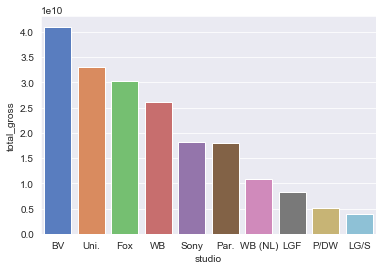

In [399]:
sns.barplot(x=top_10_studios.index, y=top_10_studios)

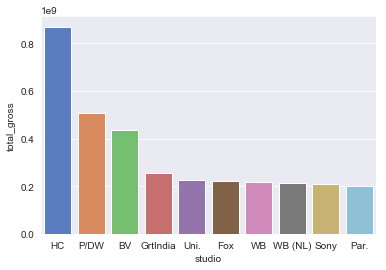

In [400]:
sns.barplot(x=top_10_studios_mean.index, y=top_10_studios_mean)

In [411]:
movies_sorted.iloc[:,11:33].sum()

Action         30
Adventure      41
Animation      12
Biography       2
Comedy         14
Crime           3
Documentary     2
Drama           5
Family          1
Fantasy         9
History         1
Horror          0
Music           1
Musical         0
Mystery         0
News            0
Romance         0
Sci-Fi         14
Sport           2
Thriller        7
War             0
Western         0
dtype: int64

In [ ]:
def find_avg_rating(df, col):
    subset = df[df[col]]

In [419]:
movies_sorted.loc[movies_sorted['Adventure'].astype(bool)].averagerating.mean()

7.295121951219514

In [420]:
movies_sorted.loc[movies_sorted['Action'].astype(bool)].averagerating.mean()

7.246666666666667

In [421]:
movies_sorted.loc[movies_sorted['Sci-Fi'].astype(bool)].averagerating.mean()

7.071428571428572

In [422]:
movies_sorted.loc[movies_sorted['Comedy'].astype(bool)].averagerating.mean()

7.392857142857144

In [461]:
tppm[tppm['actor'].astype(bool)].groupby('primary_name').mean()['averagerating'].sort_values(ascending=False)

primary_name
Mark Thomas             9.2
Nejc Hocevar            9.1
Alen Stojs Goljar       9.1
Jure Janet              9.1
Drago Graf              9.1
Primoz Vrhovec          9.1
Luke Abaffy             9.0
Sam Berger              8.9
Andres Pollard          8.8
Virgile Bramly          8.8
Tohoru Masamune         8.8
Yuji Okumoto            8.8
Mike Erickson           8.8
Alexandre Ottoveggio    8.8
John Taylor             8.8
Johnny Marr             8.8
Cillian Murphy          8.8
John Lawson             8.8
James Lew               8.8
Michael Malone          8.8
Thomas Tull             8.8
Matt Scott              8.8
Dileep Rao              8.8
Kevin Proctor           8.8
Mark Fleischmann        8.8
Elliot Levey            8.7
Oliver Castro           8.7
Nicholas Hart           8.6
James Conrado           8.6
Nelson Jacobina         8.6
                       ... 
Jiantao Hong            2.5
Jia-yi Zhang            2.5
Zhiguo Du               2.5
Zhen Yi                 2.5
Yongjia

In [432]:
tppm[tppm['primary_name'] == 'Mark Thomas']

,title,studio,domestic_gross,foreign_gross,year,primary_title,original_title,start_year,runtime_minutes,averagerating,...,publicist,set_decorator,sound_department,soundtrack,special_effects,stunts,talent_agent,transportation_department,visual_effects,writer
64276,The Runaways,App.,3600000.0,1100000,2010,The Runaways,The Runaways,2019,108.0,9.2,...,0,0,0,1,0,0,0,0,0,0
64277,The Runaways,App.,3600000.0,1100000,2010,The Runaways,The Runaways,2019,108.0,9.2,...,0,0,0,0,0,0,0,0,0,0
64278,The Runaways,App.,3600000.0,1100000,2010,The Runaways,The Runaways,2019,108.0,9.2,...,0,0,0,0,0,0,0,0,0,0


In [453]:
vc = tppm.primary_name.value_counts()
to_remove = vc[vc < 5].index

In [454]:
to_remove

Index(['David S. Lee', 'Grant Olin', 'David Farr', 'Imraan Ismail',
       'Charlie Day', 'Dean Knowsley', 'Alex Lopez', 'Dan Reynolds',
       'Sacha Skarbek', 'Deron Johnson',
       ...
       'Caleel Harris', 'Fernando Serzedelo', 'Ian Bryce', 'Han Soto',
       'Jamie Hill Fuller', 'Kevin McCorkle', 'Aleksandr Userdin',
       'Gralen Bryant Banks', 'Stephen Dunn', 'JB Blanc'],
      dtype='object', length=42018)

In [448]:
tppm2 = tppm.primary_name.replace(to_remove, False)

In [449]:
tppm2.groupby('primary_name').mean()['averagerating'].sort_values(ascending=False)

KeyError: 'primary_name'

In [517]:
actors = tppm[tppm.actor == 1]
vc = actors.primary_name.value_counts()
infrequent_actors = vc[vc <= 3].index

In [518]:
actors.set_index('primary_name', inplace=True)

In [519]:
actors.head()

,title,studio,domestic_gross,foreign_gross,year,primary_title,original_title,start_year,runtime_minutes,averagerating,...,publicist,set_decorator,sound_department,soundtrack,special_effects,stunts,talent_agent,transportation_department,visual_effects,writer
primary_name,,,,,,,,,,,,,,,,,,,,,
Avtar Gill,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
Neil Nitin Mukesh,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
Manav Kaul,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
Anjum Sharma,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,0,0,0,0,0
Ejaz Gulab,Wazir,Relbig.,1100000.0,NaN,2016,Wazir,Wazir,2016,103.0,7.1,...,0,0,0,0,0,1,0,0,0,0


In [520]:
frequent_actors = actors.drop(infrequent_actors)

In [521]:
infrequent_actors.shape

(15378,)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

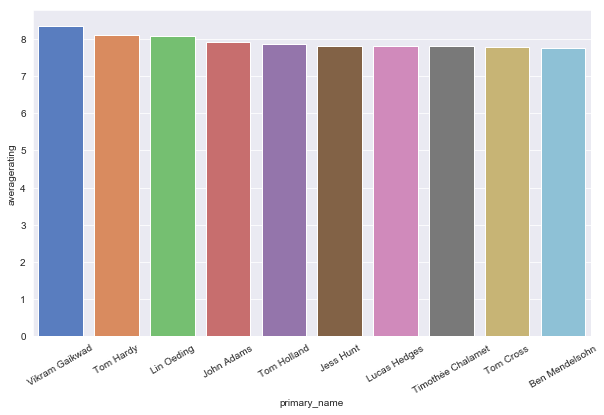

In [563]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
most_popular_actors = frequent_actors.groupby('primary_name').averagerating.mean().sort_values(ascending=False).head(10)

sns.barplot(x=most_popular_actors.index, y=most_popular_actors, ax=ax)
plt.xticks(rotation=30)




In [564]:
tppm[tppm.primary_name == 'Tom Holland']

,title,studio,domestic_gross,foreign_gross,year,primary_title,original_title,start_year,runtime_minutes,averagerating,...,publicist,set_decorator,sound_department,soundtrack,special_effects,stunts,talent_agent,transportation_department,visual_effects,writer
32328,The Impossible,LG/S,19000000.0,161300000,2012,The Impossible,Lo imposible,2012,114.0,7.6,...,0,0,0,0,0,0,0,0,0,1
32329,The Impossible,LG/S,19000000.0,161300000,2012,The Impossible,Lo imposible,2012,114.0,7.6,...,0,0,0,0,0,0,0,0,0,0
32330,Spider-Man: Homecoming,Sony,334200000.0,546000000,2017,Spider-Man: Homecoming,Spider-Man: Homecoming,2017,133.0,7.5,...,0,0,0,0,0,0,0,0,0,1
32331,Spider-Man: Homecoming,Sony,334200000.0,546000000,2017,Spider-Man: Homecoming,Spider-Man: Homecoming,2017,133.0,7.5,...,0,0,0,0,0,0,0,0,0,0
32332,Captain America: Civil War,BV,408100000.0,745200000,2016,Captain America: Civil War,Captain America: Civil War,2016,147.0,7.8,...,0,0,0,0,0,0,0,0,0,1
32333,Captain America: Civil War,BV,408100000.0,745200000,2016,Captain America: Civil War,Captain America: Civil War,2016,147.0,7.8,...,0,0,0,0,0,0,0,0,0,0
32334,Avengers: Infinity War,BV,678800000.0,1369500000,2018,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,8.5,...,0,0,0,0,0,0,0,0,0,1
32335,Avengers: Infinity War,BV,678800000.0,1369500000,2018,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,8.5,...,0,0,0,0,0,0,0,0,0,0


In [527]:
writers = tppm[tppm.writer == 1]
vc = writers.primary_name.value_counts()
infrequent_writers = vc[vc <= 3].index
writers.set_index('primary_name', inplace=True)
frequent_writers = writers.drop(infrequent_writers)
frequent_writers.groupby('primary_name').total_gross.mean().sort_values(ascending=False).head(10)

primary_name
Jim Starlin       1.272700e+09
Jacob Johnston    1.233950e+09
Doug Mallette     1.217975e+09
Adam Davis        1.100500e+09
Tom Holland       1.065525e+09
Name: total_gross, dtype: float64

In [585]:
def plot_most_popular_people(df, role, category, frequency=3, n=10, figsize=(10,6)):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    people = df[df[role] == 1]
    vc = people['primary_name'].value_counts()
    infrequent_people = vc[vc <= frequency].index
    people.set_index('primary_name', inplace=True)
    frequent_people = people.drop(infrequent_people)
    most_popular_people = frequent_people.groupby('primary_name')[category].mean().sort_values(ascending=False).head(n)
    sns.barplot(x=most_popular_people.index, y=most_popular_people, ax=ax)
    plt.xticks(rotation=30)
    plt.xlabel(str(role + "'s name"))
    plt.title(str(role + 's sorted by ' + category))
    
    

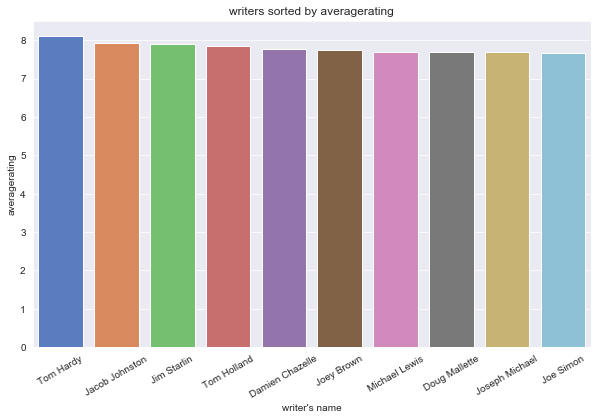

In [586]:
plot_most_popular_people(tppm, 'writer', 'averagerating')

In [534]:
movie_genres = movies_sorted.iloc[:,11:33].stack().reset_index(level=1)

In [536]:
movie_genres.name = 'stacked_genres'
movies_with_genres = movies_sorted.join(movie_genres)
movies_with_genres = movies_with_genres[movies_with_genres[0] == 1]

In [548]:
movies_with_genres_aasc = movies_with_genres[movies_with_genres['level_1'].isin(['Adventure', 
                                                                                 'Action', 
                                                                                 'Sci-Fi',
                                                                                 'Comedy'])]

Text(0.5,1,'Total Gross by Genre')

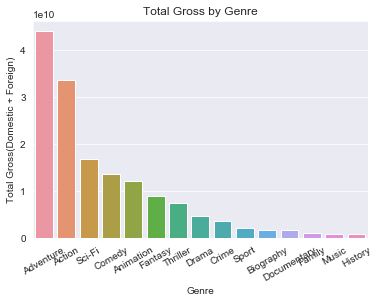

In [577]:
top_grossing_genres = movies_with_genres.groupby('level_1')['total_gross'].sum().sort_values(ascending=False)

sns.barplot(x=top_grossing_genres.index, y=top_grossing_genres)
plt.xticks(rotation=30)
plt.xlabel('Genre')
plt.ylabel('Total Gross(Domestic + Foreign)')
plt.title('Total Gross by Genre')

Text(0.5,1,'Total Gross by Genre')

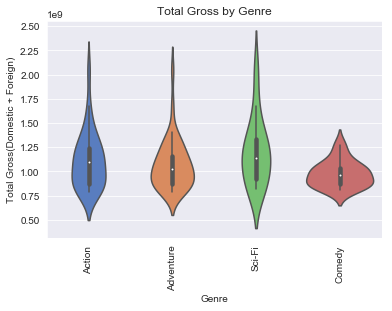

In [578]:
x = sns.violinplot(x='level_1', y='total_gross', data=movies_with_genres_aasc)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Total Gross(Domestic + Foreign)')
plt.title('Total Gross by Genre')

In [542]:
movies_with_genres.head()

,title,studio,domestic_gross,foreign_gross,year,primary_title,original_title,start_year,runtime_minutes,averagerating,...,News,Romance,Sci-Fi,Sport,Thriller,War,Western,total_gross,level_1,0
286,Black Panther,BV,700100000.0,646900000,2018,Black Panther,Black Panther,2018,134.0,7.3,...,0,0,1,0,0,0,0,1.347000e+09,Action,1
286,Black Panther,BV,700100000.0,646900000,2018,Black Panther,Black Panther,2018,134.0,7.3,...,0,0,1,0,0,0,0,1.347000e+09,Adventure,1
286,Black Panther,BV,700100000.0,646900000,2018,Black Panther,Black Panther,2018,134.0,7.3,...,0,0,1,0,0,0,0,1.347000e+09,Sci-Fi,1
373,Jurassic World,Uni.,652300000.0,1019440000,2015,Jurassic World,Jurassic World,2015,124.0,7.0,...,0,0,1,0,0,0,0,1.671740e+09,Action,1
373,Jurassic World,Uni.,652300000.0,1019440000,2015,Jurassic World,Jurassic World,2015,124.0,7.0,...,0,0,1,0,0,0,0,1.671740e+09,Adventure,1
